<a href="https://colab.research.google.com/github/long4coventry/6057CEM/blob/main/CNN_fooled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_mldata
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

%matplotlib inline

plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['image.cmap'] = 'Dark2'

# Fooling Deep Learning

Several studies have come out on how to fool a Deep Neural Network (DNN). In the most famous study in 2015 the team used evolutionary
algorithms or gradient ascent to produce the adversarial images [^1]. Recently a new study revealed that fooling a DNN could be achieved by changing a single pixel[^2]. This subject seems fun and all but has substantial implications on current and future applications of Deep Learning, so I believe that understanding what makes these models tick is extremely important.[^3]

A comprehensive and very complete summary can be found in the [When DNNs go wrong](https://blog.acolyer.org/2017/02/28/when-dnns-go-wrong-adversarial-examples-and-what-we-can-learn-from-them/) blog, which I recommend you to read.

All these amazing studies use state of the art Deep Learning techniques, which makes them in my opinion not easy to reproduce and makes it difficult to answer questions we might have as non-experts in this subject.

My intention in this blog is to bring the main concepts down to earth to an easily reproducible setting where they are clear and actually visible. In addition, I hope this short blog can provide a better understanding of the limitations of discriminative models in general. 


[^1]: [Deep Neural Networks are Easily Fooled](http://www.evolvingai.org/files/DNNsEasilyFooled_cvpr15.pdf)
[^2]: [One pixel attack for fooling deep neural networks](https://arxiv.org/pdf/1710.08864.pdf)
[^3]: This should be the case not only for Deep Learning models but all models in general. I increasingly see pseudo Data Scientist making outrageous claims or using models with a one-fits-all mentality. I understand there are juniors in the organizations but that's why you should have a strong Lead Data Scientist or hire us to make your team blossom, not only on their technical abilities but in the mentality when attacking a problem as well.

Neural Networks in general belong to the family of Discriminative models, these type of models try to model the dependence of an unobserved variable (target) based on observed input (features). In the language of probability this scenario is represented by the conditional probability and it is expressed as:

$$p(target|features)$$

it reads: the probability of the target given the features (i.e. the probability it will rain based on yesterday's weather, temperature and pressure measurements).

Multinomial logistic regression is also part of these discriminative models and it can be seen as a neural network without a hidden layer. Don't be dissapointed but I will start by demonstrating some concepts using multinomial logistic regression and then expand to a deep neural network keeping the same ideas.  

# TELL MORE ABOUT.

# Fooling Multinomial logistic regression

As mentioned before a multinomial logistic regression can be seen as a Neural Network without a hidden layer. It models the probability of the target ($Y$) being a certain category ($c$), as a function ($F$) that depends on the linear combination of the features ($X=(X_1, X_2,...,X_N)$). We write this as:

$$P(Y=c|X)=F(\theta_{c}^T\cdot X)$$

where $\theta_c$ are the coefficients of the linear combination for each category. Then the predicted class is the one which gives the highest probability.

When the target $Y$ is binary $F$ is taken to be some [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), the most common being the [logistic function](https://en.wikipedia.org/wiki/Logistic_function). When $Y$ is multiclass we commonly use $F$ as the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

Appart from the conceptual understanding of discriminative models discussed before, is this linear combination of the features what makes classification models vulnerable. In the own words of Master Jedi Goodfellow: "Linear behavior in high-dimensional spaces is suf-
ficient to cause adversarial examples" [^3].

[^3]: https://arxiv.org/pdf/1412.6572.pdf


### Iris dataset

When I was thinking on how to do this blog and actually show the concepts with a nice plot I concluded I needed two things:

 - A 2 dimensional feature space.
 - A model with high accuracy on this space.
 
This 2 dimensional space because I wanted to generate plots which directly show the concepts and a high accuracy because if I am able to fool a very bad model that doesn't really tell much.

Lucky for me it turns out that a good accuracy can be obtain on the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) by just keeping two features: petal length and petal width.

Putting everything into shape this is how our data looks like

In [ ]:
iris_dataset = load_iris()
keep_cols = ['petal length (cm)', 'petal width (cm)']
target_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
iris = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)[keep_cols]
iris['flower'] = iris_dataset.target
iris.flower = iris.flower.map(target_map).astype('category')
iris.sample(10)

,petal length (cm),petal width (cm),flower
109,6.1,2.5,virginica
60,3.5,1.0,versicolor
31,1.5,0.4,setosa
58,4.6,1.3,versicolor
128,5.6,2.1,virginica
108,5.8,1.8,virginica
11,1.6,0.2,setosa
17,1.4,0.3,setosa
52,4.9,1.5,versicolor
24,1.9,0.2,setosa


This dataset contains only 150 observations, I will fit the model to all the data using a cross-entropy loss function and a L2 regularization term. This is just a plug and play from the amazing scikit-learn. 

```python
model = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='multinomial', penalty='l2')
model.fit(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)
```

In [ ]:
model = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='multinomial', penalty='l2')
model.fit(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)
model.score(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)
# model = RandomForestClassifier(n_estimators=1000)
# model = SVC(kernel='linear', probability=True)
# model = SVC(kernel='poly', probability=True)
# model = SVC(kernel='rbf', probability=True)

0.96666666666666667

The mean accuracy of the of the model is $96.6%$. This score is based on the training data and can be misleading, even if I am using a regularization term I can still be overfitting.[^4]

Let's know look at our predictions and at how our classifier is drawing the classification boundaries. 


[^4]: For the demonstration I decided to train on all the data since the dataset is so small (150 observations). In the Deep Neural Network case I will use a much larger dataset and a test set.

In [ ]:
iris['prediction'] = model.predict(X=iris.loc[:, iris.columns != 'flower'])
iris['prediction'] = iris['prediction'].astype('category')
iris['success'] = iris['prediction'] == iris['flower']

In [ ]:
all_sizes = pd.DataFrame(data=np.mgrid[0.9:7:200j, 0:2.6:200j].reshape(2,-1).T,
                         columns=['length', 'width'])
all_sizes['prediction'] = model.predict(all_sizes[['length', 'width']])
all_sizes['prediction'] = all_sizes['prediction'].astype('category')
all_sizes['probability'] = np.max(model.predict_proba(all_sizes[['length', 'width']]), axis=1)


all_sizes_focus = pd.DataFrame(data=np.mgrid[2:3:500j, 3:4:500j].reshape(2,-1).T,
                               columns=['length', 'width'])
all_sizes_focus['prediction'] = model.predict(all_sizes_focus[['length', 'width']])
all_sizes_focus['prediction'] = all_sizes_focus['prediction'].astype('category')
all_sizes_focus['probability'] = np.max(model.predict_proba(all_sizes_focus[['length', 'width']]), axis=1)

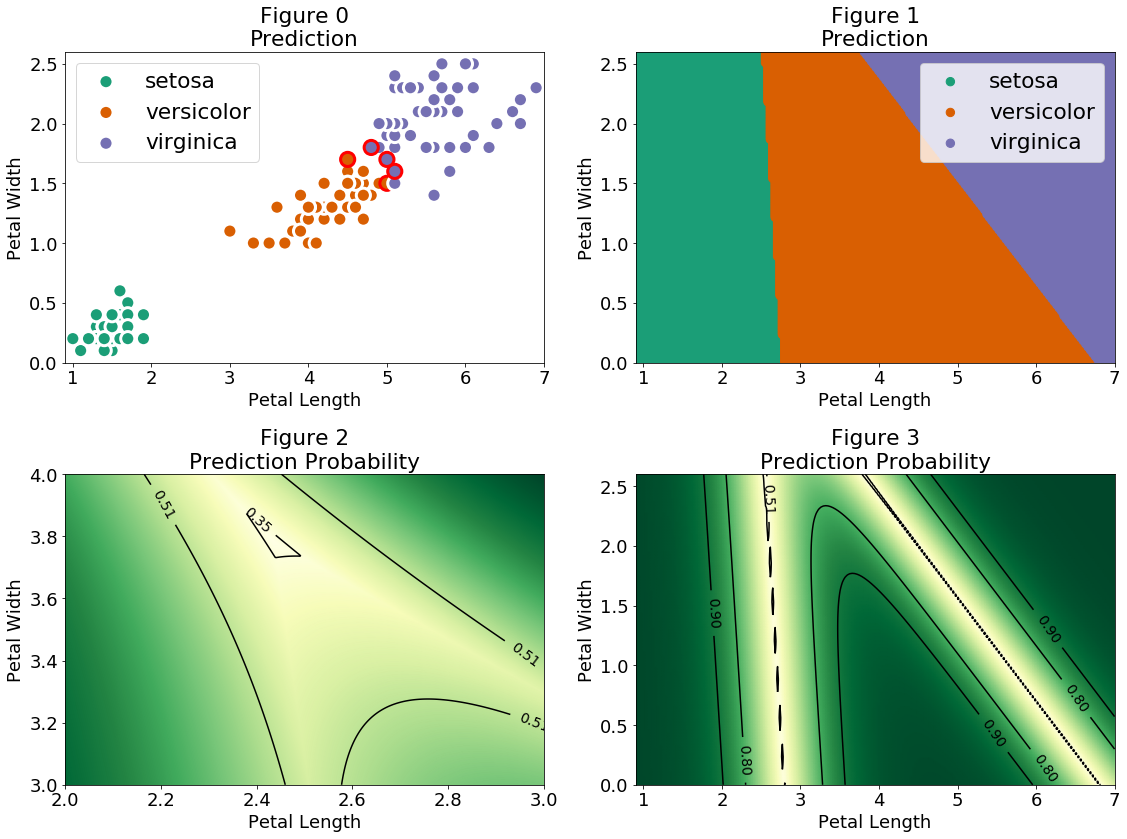

In [ ]:
colormap = plt.cm.Dark2
fig, ax = plt.subplots(2, 2, figsize=(16,12))
for label, df in iris.groupby('prediction'):
    df = df.sort_values('success', ascending=False)
    df.plot.scatter('petal length (cm)', 'petal width (cm)', ax=ax[0, 0], label=label,
                    edgecolors=df.success.map({True: 'w', False: 'r'}), linewidths=3, s=200,
                    c=df.prediction.cat.codes.map(lambda x: colormap(x)))
ax[0, 0].set_xlabel('Petal Length')
ax[0, 0].set_ylabel('Petal Width')
ax[0, 0].set_title('Figure 0\nPrediction')
ax[0, 0].set_xlim((0.9, 7))
ax[0, 0].set_ylim((0, 2.6))
ax[0, 0].legend();

for label, df in all_sizes.groupby('prediction'):
    ax[0, 1].scatter(df.length, df.width, label=label, s=70,
                     c=df.prediction.cat.codes.map(lambda x: colormap(x)))
ax[0, 1].set_xlabel('Petal Length')
ax[0, 1].set_ylabel('Petal Width')
ax[0, 1].set_title('Figure 1\nPrediction')
ax[0, 1].set_xlim((0.9, 7))
ax[0, 1].set_ylim((0, 2.6))
ax[0, 1].legend();

df = all_sizes_focus.pivot(index='width', columns='length', values='probability')
levels = [0.35, 0.51]
pp = ax[1, 0].pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax[1, 0].contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)
# plt.colorbar(pp, ax=ax[1, 0])
ax[1, 0].set_xlabel('Petal Length')
ax[1, 0].set_ylabel('Petal Width')
ax[1, 0].set_title('Figure 2\nPrediction Probability')

df = all_sizes.pivot(index='width', columns='length', values='probability')
levels = [0.3, 0.507, 0.8, 0.9]
pp = ax[1, 1].pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax[1, 1].contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)
# plt.colorbar(pp, ax=ax[1, 1])
ax[1, 1].set_xlabel('Petal Length')
ax[1, 1].set_ylabel('Petal Width')
ax[1, 1].set_title('Figure 3\nPrediction Probability')

fig.tight_layout()
fig.savefig('iris_predictions.png')

In Figure 0 the red outter circles indicate those observations that were wrongly classified. The setosa flowers are easily identified and there is a region where the setosa and virginica overlap. In Figure 1 we can see the different regions for each flower category. The regions are separated by a linear boundary, this is a consequence of the linear combination model used $P(Y=c|X)=F(\theta_{c}^T\cdot X)$. As mentioned, in the case of a logistic regression (binary classification) $F$ is the logistic function

$$F(\theta_{c}^T\cdot X)=\frac{1}{1 + e^{-\theta_{c}^T\cdot X}}$$

and the classification boundary is given by $P(Y=c|X)=\frac{1}{2}$ when $\theta_{c}^T\cdot X=0$. If the features are in 1 dimension then the boundary will be a single value, for two features the boundary is a single line and for three features a plane and so on. In our multinomial case we use the softmax function

$$F(\theta_{c}^T\cdot X)=\frac{e^{\theta_{c}^T\cdot X}}{\Sigma_{i=1}^Ne^{-\theta_{i}^T\cdot X}}$$

where the sum over $i$ in the denominator runs over all the possible classes of the target. In the regions where only two classes have a non-negligible probability the softmax function simplifies to the logisitc function and therefore the linear classification boundaries between two regions given by the countour $P(Y=c|X)=\frac{1}{2}$ as shown in Figure 3. In addition when none of the classes have beglible proability the boundary approaches the countour $P(Y=c|X)=\frac{1}{3}$ where the uncertainty of our prediction is maximum, this region is illustrated in Figure 2.

A thing to note is that the regions extend to values which can be very far from the observation features, which means we could grab a Petal Length of 1 and Petal Width of 2.5 and still be classified as a Setosa even though the features are not even close to where the Setosa observations are. Evenmore, Figure 4 shows that even far away from our observations we can find regions with extremely high probability. We can even use a negative petal length!

In [ ]:
all_sizes = pd.DataFrame(data=np.mgrid[-1:10:400j, -1:5:400j].reshape(2,-1).T,
                         columns=['length', 'width'])
all_sizes['prediction'] = model.predict(all_sizes[['length', 'width']])
all_sizes['prediction'] = all_sizes['prediction'].astype('category')
all_sizes['probability'] = np.max(model.predict_proba(all_sizes[['length', 'width']]), axis=1)
all_sizes['alpha'] = (all_sizes['probability'] - np.min(all_sizes['probability'])) / (np.max(all_sizes['probability']) - np.min(all_sizes['probability']))

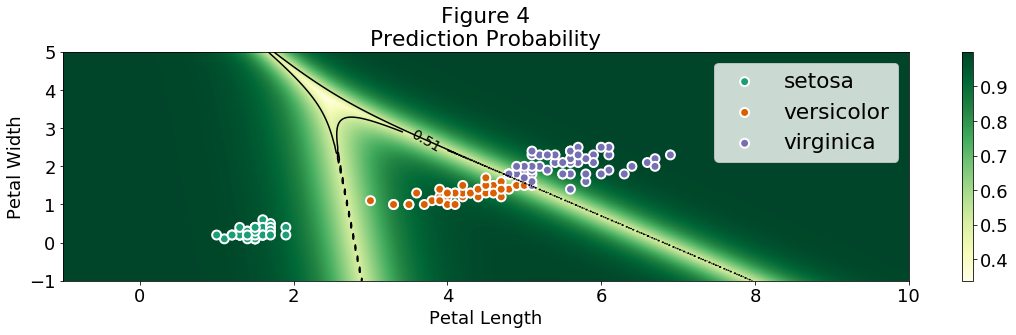

In [ ]:
df = all_sizes.pivot(index='width', columns='length', values='probability')

fig, ax = plt.subplots()
levels = [0.33, 0.505]
pp = ax.pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax.contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.colorbar(pp, ax=ax)
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)

for label, df in iris.groupby('prediction'):
    df = df.sort_values('success', ascending=False)
    df.plot.scatter('petal length (cm)', 'petal width (cm)', ax=ax, label=label,
                    edgecolors='w', linewidths=2, s=80,
                    c=df.prediction.cat.codes.map(lambda x: colormap(x)))
ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_title('Figure 4\nPrediction Probability');

fig.tight_layout()
fig.savefig('iris_regions.png')

Let's pick some point from Figure 4 and see if I am able to fool the multinomial logistic classifier:

 - Region setosa: (.1, 5) 
 - Region virginica: (10, 10)
 - Region versicolor: (5, -5)

In [ ]:
v = [.1, 5]
print(model.predict(v)[0])
print(np.max(model.predict_proba(v)))

setosa
0.997968313211


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [ ]:
v = [10, 10]
print(model.predict(v)[0])
print(np.max(model.predict_proba(v)))

virginica
1.0


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [ ]:
v = [5, -5]
print(model.predict(v)[0])
print(np.max(model.predict_proba(v)))

versicolor
0.992700168173


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


The three points give a high confidence on the prediction but are not even remotly like the observations in our dataset.

Ok, now to the good stuff.

# Deep Neural Network


As I said before in order for me to demonstrate the concepts and have a comprehensive visualization I need two things

 - A 2 dimensional feature space.
 - A model with high accuracy on this space.
 
In the case of a Deep Neural Network it makes no sense to attack a problem with 2 features, as the intent of neural network is to throw a bunch of features as the input layer and let the hidden layers figure out and construct new features which are relevant to my classification problem. So my reasoning as how to solve my first requirement goes as follows:

 1. Build a Deep Neural Network where the last hidden layer has two units. 
 2. Then do the space analysis on the features from that layer.
 3. Pick a point on that layer space which is far from the propagated observations but still is classified with a high probability.
 4. Invert all the operations made from the input layer to that last hidden layer and apply them to my selected 2D point on 3.

If I can perform those steps I should end with an input which is nothing like my observations but still is classified with high probability by the Deep Neural network, giving me an adversarial example.

## MNIST

I chose the [MNIST](http://yann.lecun.com/exdb/mnist/) digits since it is a straight forward dataset to perform classification and it is complex enough to apply a Deep Neural Network. I only take 4 classes, the numbers ${0, 1, 2, 3}$ and the dataset consist of a bit more than 28000 observations with 28x28=784 features.

```python
digits = fetch_mldata("MNIST original")
index = np.in1d(digits.target, [0, 1, 2, 3])
digits.data = digits.data[index]
digits.target = digits.target[index]
```
```
Number of observations: 28911
Nr. observstiosn per class:
1.0    7877
3.0    7141
2.0    6990
0.0    6903
```

In [ ]:
digits = fetch_mldata("MNIST original")

In [ ]:
index = np.in1d(digits.target, [0, 1, 2, 3])
digits.data = digits.data[index]
digits.target = digits.target[index]
print('Number of observations: {}'.format(len(digits.target)))
print('Nr. observstiosn per class:\n{}'.format(pd.Series(digits.target).value_counts()))

Number of observations: 28911
Nr. observstiosn per class:
1.0    7877
3.0    7141
2.0    6990
0.0    6903
dtype: int64


An sample view of our observations:

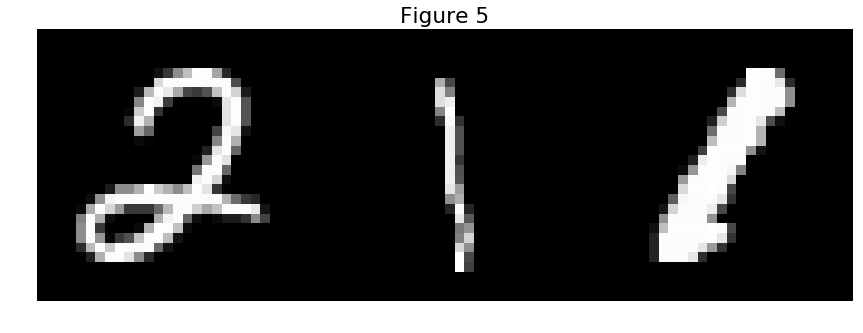

In [ ]:
index = np.random.randint(0, digits.data.shape[0], 3)
img = np.concatenate((
    digits.data[index[0]].reshape((28,28)),
    digits.data[index[1]].reshape((28,28)),
    digits.data[index[2]].reshape((28,28))
), axis=1)
plt.imshow(img, cmap='gray')
plt.title('Figure 5')
plt.axis('off');
plt.savefig('digits_sample.png')

## DNN configuration

The challenge here is to find the correct configuration such that the training of the DNN  converges and has a good performance on the training set.

In addition, in order to be able to invert all the operations from the input layer to the last hidden layer then all functions applied must have an inverse. This mean that if I decided to use any of the activation functions provided: logistic, tanh and relu, I need to keep track and impose restrictions on my nodes activation so that they belong to the codomain of the activation function. This is not trivial and in my opinion does not add much to the concepts I'm trying to get accross. Therefore I use the identity activation which can make the convergence a bit more tricky. [^6]


The final configuration of the DNN consists of:

 - 3 hidden layers with sizes {50, 20, 2}.
 - Identity activation function (no acivation function).
 - Stochastic Gradient Descent optimizer (sgd).
 - Adaptive learning rate.


```python
dnn_identity = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='identity',
    solver='sgd',
    learning_rate = 'adaptive', learning_rate_init=.00005,
    random_state=21
)
```

The DNN achieved close to 95% accuracy and reached conversion quite nicely as shown in Figure 6. For comparison and for use in my arguments I will built another DNN with an activation function $tanh$ using the Adam optimizer.

```python
dnn_tanh = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='tanh',
    solver='adam',
    learning_rate_init=.0001,
    random_state=21
)
```

The second DNN with the activation function achieved an accuracy of 98%, the loss curve in Figure 7 reveals that the training can be further improved but for now this is good enough.

[^6]: It is known that no activation function can lead to exploting activations values which in turn affect the convergence of the Deep Neural Network.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)

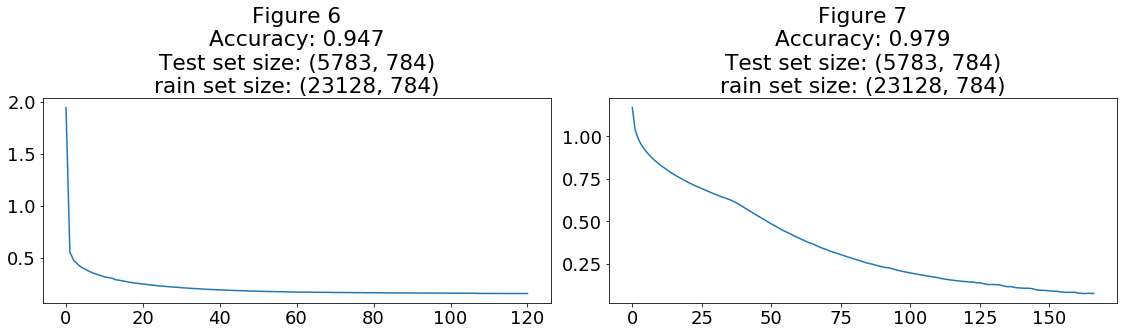

In [ ]:
dnn_identity = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='identity',
    solver='sgd',
    learning_rate = 'adaptive', learning_rate_init=.00005,
    random_state=21
)
dnn_tanh = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='tanh',
    solver='adam',
    learning_rate_init=.0001,
    random_state=21
)

dnn_identity.fit(X_train, y_train)
dnn_tanh.fit(X_train, y_train)


fig, ax = plt.subplots(1, 2)
ax[0].plot(dnn_identity.loss_curve_)
ax[0].set_title(("Figure 6\n"
           "Accuracy: {:.3f}\n"
           "Test set size: {}\n"
           "rain set size: {}")
          .format(dnn_identity.score(X_test, y_test), X_test.shape, X_train.shape))

ax[1].plot(dnn_tanh.loss_curve_)
ax[1].set_title(("Figure 7\n"
           "Accuracy: {:.3f}\n"
           "Test set size: {}\n"
           "rain set size: {}")
          .format(dnn_tanh.score(X_test, y_test), X_test.shape, X_train.shape));

fig.tight_layout()
fig.savefig('loss_curve.png')

## Extract feature encoding from the last hidden layer

Once the model is trained we can retrieve the coefficients connecting all the layers, we use these coeficients to "manually" propagate our observations input up to the last hidden layer and then plot some of them in a 2D graph. This small function propagates the input layer up to a specified layer.

```python
def propagate(input_layer, layer_nr, dnn, activation_function):
    """Obtain the activation values of any intermediate layer of the deep neural network.
    """
    layer = input_layer
    for intercepts, weights in zip(dnn.intercepts_[:layer_nr], dnn.coefs_[:layer_nr]):
        layer = activation_function(layer.dot(weights) + intercepts)
    return layer

hl_identity = propagate(digits.data, 3, dnn_identity, lambda x: x)
hl_tanh = propagate(digits.data, 3, dnn_tanh, np.tanh)
```


In [ ]:
def propagate(input_layer, layer_nr, dnn, activation_function):
    """Obtain the activation values of any intermediate layer of the neural network.
    """
    layer = input_layer
    for intercepts, weights in zip(dnn.intercepts_[:layer_nr], dnn.coefs_[:layer_nr]):
        layer = activation_function(layer.dot(weights) + intercepts)
    return layer

In [ ]:
hl_identity = propagate(digits.data, 3, dnn_identity, lambda x: x)
hl_tanh = propagate(digits.data, 3, dnn_tanh, np.tanh)

Check that probabilities indeed are correct

In [ ]:
# apply the last transformation from the hidden layer to the output layer
last_layer = dnn_identity.intercepts_[-1] + hl_identity.dot(dnn_identity.coefs_[-1])
# convert to probabilities
e = np.exp(last_layer)
e_sum = np.sum(e, axis=1, keepdims=True)
probabilities = np.divide(e, e_sum)
# check the probability of a random observation
i = np.random.randint(0, probabilities.shape[0])
print('Probabilty using hidden layer output:\n{}'.format(probabilities[i]))
print('\nProbabilty using the complete neural network:\n{}'.format(dnn_identity.predict_proba(digits.data[i].reshape(1, -1))))
# check that all predictions are the same
predictions = np.argmax(probabilities, axis=1)
print('\nAre all prediction the same using the hidden layer and the full neural network?\n{}'
      .format((dnn_identity.predict(digits.data) == predictions).all()))

Probabilty using hidden layer output:
[  1.97784502e-08   8.97105199e-06   8.30823773e-03   9.91682771e-01]

Probabilty using the complete neural network:
[[  1.97784502e-08   8.97105199e-06   8.30823773e-03   9.91682771e-01]]

Are all prediction the same using the hidden layer and the full neural network?
True


The representation of the observations under the encoding of the last 2D hidden layer is shown on Figure 7 and 8. The identity DNN, as shown in Figure 7, has encoded our observations by creating hideen features which separate them in the hidden layer dimensionalty (2D in this case). The more sophisticated $tanh$ DNN achieves metter performance because it is capable of coming up with hidden features which separate in a better way our observations as shown in Figure 8. Nevertheless Figures 9 and 10 reveal that in both cases linear classification boundaries are being constructed to separate our category regions. As in the multinomial logistic regression this again because of the dot product (linear Kernel) between the last hidden layer and the final weights which connect this last hidden layer with the output layer of our DNN. This means that these regions extend far away from where our observations lie, evenmore these regions have a high probability was shown in Figure 12 and 13.

So now the only thing to do is for example, grab a point (-200, 200) from Figure 8, do all the inverse operations to bring back the encoding to the input layer and reshape the vector into an image which of course will look nothing like a $1$ but will be classified as a $1$ with very high probability by our DNN.

In [ ]:
def predict(layer_2D, dnn):
    last_layer = dnn.intercepts_[-1] + layer_2D.dot(dnn.coefs_[-1])
    # convert to probabilities
    e = np.exp(last_layer)
    e_sum = np.sum(e, axis=1, keepdims=True)
    probabilities = np.divide(e, e_sum)
    predictions = np.argmax(probabilities, axis=1)
    return predictions

In [ ]:
predictions_identity = dnn_identity.predict(digits.data)
encodings_identity = pd.DataFrame(data= np.c_[hl_identity, predictions_identity],
                   columns= ['hidden_feature_0', 'hidden_feature_1', 'prediction'])
encodings_identity['success'] = encodings_identity.prediction == digits.target

predictions_tanh = dnn_tanh.predict(digits.data)
encodings_tanh = pd.DataFrame(data= np.c_[hl_tanh, predictions_tanh],
                   columns= ['hidden_feature_0', 'hidden_feature_1', 'prediction'])
encodings_tanh['success'] = encodings_tanh.prediction == digits.target

grid_identity = np.mgrid[-600:1000:200j, -400:400:200j].reshape(2,-1).T
last_layer = dnn_identity.intercepts_[-1] + grid_identity.dot(dnn_identity.coefs_[-1])
e = np.exp(last_layer)
e_sum = np.sum(e, axis=1, keepdims=True)
prob_identity = np.divide(e, e_sum)
pred_identity = np.argmax(prob_identity, axis=1)
prob_identity = np.max(prob_identity,  axis=1)
grid_encodings_identity = pd.DataFrame(data= np.c_[grid_identity, pred_identity, prob_identity],
                                    columns= ['hidden_feature_0', 'hidden_feature_1', 'prediction', 'probability'])

grid_tanh = np.mgrid[-1:1:200j, -1:1:200j].reshape(2,-1).T
last_layer = dnn_tanh.intercepts_[-1] + grid_tanh.dot(dnn_tanh.coefs_[-1])
e = np.exp(last_layer)
e_sum = np.sum(e, axis=1, keepdims=True)
prob_tanh = np.divide(e, e_sum)
pred_tanh = np.argmax(prob_tanh, axis=1)
prob_tanh = np.max(prob_tanh,  axis=1)
grid_encodings_tanh = pd.DataFrame(data= np.c_[grid_tanh, pred_tanh, prob_tanh],
                                   columns= ['hidden_feature_0', 'hidden_feature_1', 'prediction', 'probability'])

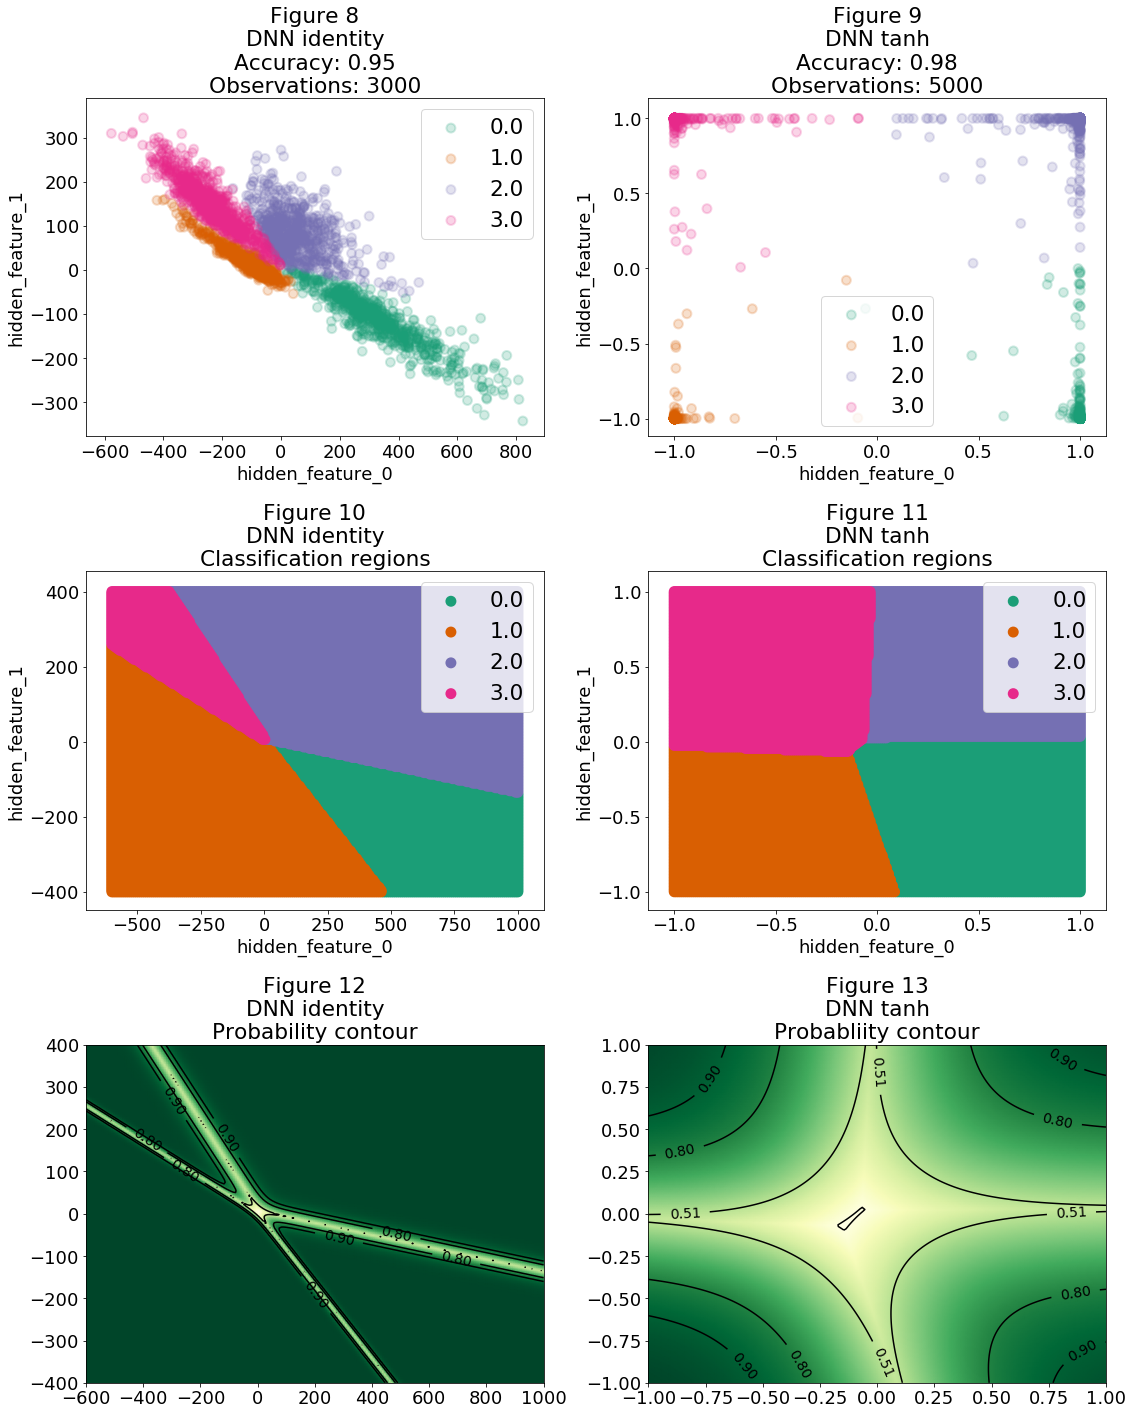

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20))

for label, df in encodings_identity.sample(3000).groupby('prediction'):
    ax[0, 0].scatter(df.hidden_feature_0, df.hidden_feature_1, label=label,
               linewidths=2, s=80, alpha=.2,
               c=df.prediction.map(lambda x: colormap(int(x))))
ax[0, 0].set_xlabel('hidden_feature_0')
ax[0, 0].set_ylabel('hidden_feature_1')
ax[0, 0].legend();
ax[0, 0].set_title("Figure 8\n"
                   "DNN identity\nAccuracy: {:.2f}\n"
                   "Observations: 3000".format(dnn_identity.score(X_test, y_test)));

for label, df in encodings_tanh.sample(5000).groupby('prediction'):
    ax[0, 1].scatter(df.hidden_feature_0, df.hidden_feature_1, label=label,
               linewidths=2, s=80, alpha=.2,
               c=df.prediction.map(lambda x: colormap(int(x))))
ax[0, 1].set_xlabel('hidden_feature_0')
ax[0, 1].set_ylabel('hidden_feature_1')
ax[0, 1].set_title('Prediction')
ax[0, 1].legend();
ax[0, 1].set_title("Figure 9\n"
                   "DNN tanh\nAccuracy: {:.2f}\n"
                   "Observations: 5000".format(dnn_tanh.score(X_test, y_test)));

for label, df in grid_encodings_identity.groupby('prediction'):
    ax[1, 0].scatter(df.hidden_feature_0, df.hidden_feature_1, label=label,
               linewidths=2, s=80,
               c=df.prediction.map(lambda x: colormap(int(x))))
ax[1, 0].set_xlabel('hidden_feature_0')
ax[1, 0].set_ylabel('hidden_feature_1')
ax[1, 0].set_title("Figure 10\nDNN identity\nClassification regions")
ax[1, 0].legend();

for label, df in grid_encodings_tanh.groupby('prediction'):
    ax[1, 1].scatter(df.hidden_feature_0, df.hidden_feature_1, label=label,
               linewidths=2, s=80,
               c=df.prediction.map(lambda x: colormap(int(x))))
ax[1, 1].set_xlabel('hidden_feature_0')
ax[1, 1].set_ylabel('hidden_feature_1')
ax[1, 1].set_title("Figure 11\nDNN tanh\nClassification regions")
ax[1, 1].legend();


df = grid_encodings_identity.pivot(index='hidden_feature_1', columns='hidden_feature_0', values='probability')
levels = [0.28, 0.507, 0.8, 0.9]
pp = ax[2, 0].pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax[2, 0].contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)
ax[2, 0].set_title("Figure 12\nDNN identity\nProbability contour")

df = grid_encodings_tanh.pivot(index='hidden_feature_1', columns='hidden_feature_0', values='probability')
levels = [0.28, 0.507, 0.8, 0.9]
pp = ax[2, 1].pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax[2, 1].contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)
ax[2, 1].set_title("Figure 13\nDNN tanh\nProbabliity contour")

fig.tight_layout()
fig.savefig('dnn_predictions.png')

Before procedding I would like to have a more conceptual discussion regarding the implications of the arguments presented for figure 8 and 9. As stated before and shown in the figures, the DNN creates hidden features which separate our observations as best as possible. This means that such hidden features will concentrate on capturing differences between our classes. For example, let's say we want to classify cats, dogs and horses, according to our reasoning will a feature that captures the amount of legs will be created? I think not because having such a features adds nothing to the purpose of separating our classes, which mean that we would send a horse with 5 legs and this fact will not raise any flags on our DNN. I believe this is the underlaying concept when we say that discriminative models do not capture the escence of tha objects to be classified. Here is where generative models come to the rescue and resently have shown amazing results by capturing the underlying "context" of the objects. In a probaiblity framework they shift from modelling the conditional probability to model the joint probability.

Notice that the probability near the boundaries grows exponentially with the product $\theta_c\cdot X$ following the sigmoid function, this means that if we take an observation which lies close to a boundary it takes a small perturbation to take it to another region. This is the principle behind the study of fooling a DNN with a single pixel change.[^2]  

Finally notice that all our analysis is in a 2D space and as such the regions extend in a surface. In a 3D space these regions will become volumes hence increasing the region size where adversarial examples can be found. Just like Master Jedi Goodfellow said: "Linear behavior in high-dimensional spaces is suf-
ficient to cause adversarial examples" [^3].




[^2]: [One pixel attack for fooling deep neural networks](https://arxiv.org/pdf/1710.08864.pdf)
[^3]: https://arxiv.org/pdf/1412.6572.pdf

## Bring it home

A bit of linear algebra. Two consecutive layers can be describe by a set of linear equations which in matrix notation can be represented by:[^6]

$$L_{N}^i\times \Theta_{N\times M}=L_{M}^{i+1}$$

where $i$ is certain layer number, $N$ and $M$ the number of units in the layer and $\Theta$ the coefficients representing the connections between layers. In a our DNN each layer reduces size, this means that $N>M$. In order to find the layer $i$ from the layer $i+1$ we need to find the inverse of $\Theta_{N\times M}$ and compute

$$L_{N}^i=L_{M}^{i+1}\times \Theta_{N\times M}^{-1}$$

The problem (of course) is that non-square matrices do not have an inverse. In our DNN context what is happening is that we are losing information by compacting our observations in a lower dimensional space, which means there is no way to exactly trace back layers, simply because we dont have enough information to do that. This does not mean that we cannot find a vector representing $L^i_N$ which satisfies $L_{N}^i\times \Theta_{N\times M}=L_{M}^{i+1}$ given the layer $L^{i+1}_M$ and the coefficients $\Theta_{N\times M}$, which means is that such vector is not unique.

A solution for the layer $L_{N}^i$ can be derived using the pseudoinverse, in particular the [Moore–Penrose inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) is adequate for our type of problem, and best of all it is implemented in Numpy!

Below I define a function which inverts the propagation from a $i+n$ layer to the input layer with an identity activation function.[^2]

```python
def invert_propagation(hidden_layer, layer_nr, dnn):
    """Obtain the input layer from a hidden layer of a deep neural network"""
    layer = hidden_layer
    for intercepts, weights in zip(nn.intercepts_[layer_nr::-1], nn.coefs_[layer_nr::-1]):
        inv_weight = np.linalg.pinv(weights)
        layer = (layer - intercepts).dot(inv_weight)
    return layer
```

[^6]: This is taking into account the intercept into the coefficients and adding a unit to layer $i$ with an activation of 1.
[^7]: If you were to use an activation function here is where you need to be careful that activation stay in the codomain of activation function. Since we cannot exctly reconstruct the previous layer we cannot be sure that the pseudo inverse will yield values which are outside the codomain therefore generating an exception. I tried a little bit with the `atanh` activation function but at least for me it was not straight forward.

In [ ]:
def invert_propagation(hidden_layer, layer_nr, dnn):
    """Obtain the input layer from a hidden layer of a deep neural network"""
    layer = hidden_layer
    for intercepts, weights in zip(dnn.intercepts_[layer_nr::-1], dnn.coefs_[layer_nr::-1]):
        inv_weight = np.linalg.pinv(weights)
        layer = (layer - intercepts).dot(inv_weight)
    return layer

In [ ]:
def pity_the_fool(hidden_vector, dnn, ax):
    input_vector = invert_propagation(hidden_vector, 2, dnn_identity)
    ax.imshow(input_vector.reshape((28,28)), cmap='gray')
    
    prediction = dnn.predict(input_vector.reshape(1, -1))[0]
    probability = np.max(dnn.predict_proba(input_vector.reshape(1, -1)))
    
    ax.set_title("Prediction: {:.0f}\n"
                 "Probability: {:.3f}\n"
                 "Hiden vector: {}"
                 .format(prediction, probability, hidden_vector))
    ax.axis('off')

Finally, to the moment of truth. I choose a non-sense value for each region by looking at Figures 10 and 12. In particular I choose:

 - Region 0: (1200, -300)
 - Region 1: (-500, 500)
 - Region 2: (100,400)
 - Region 3: (-1000, 900)
 
Now I invert the propagation for each point, obtain input layer, reshape the input to a 28x28 imagine and show it together with the prediction from the DNN and the probability of such prediction.

```python
def pity_the_fool(hidden_vector, dnn, ax):
    input_vector = invert_propagation(hidden_vector, 2, dnn_identity)
    ax.imshow(input_vector.reshape((28, 28)), cmap='gray')
    
    prediction = dnn.predict(input_vector.reshape(1, -1))[0]
    probability = np.max(dnn.predict_proba(input_vector.reshape(1, -1)))
    
    ax.set_title("Prediction: {:.0f}\n"
                 "Probability: {:.3f}\n"
                 "Hiden vector: {}"
                 .format(prediction, probability, hidden_vector))
    ax.axis('off')
```

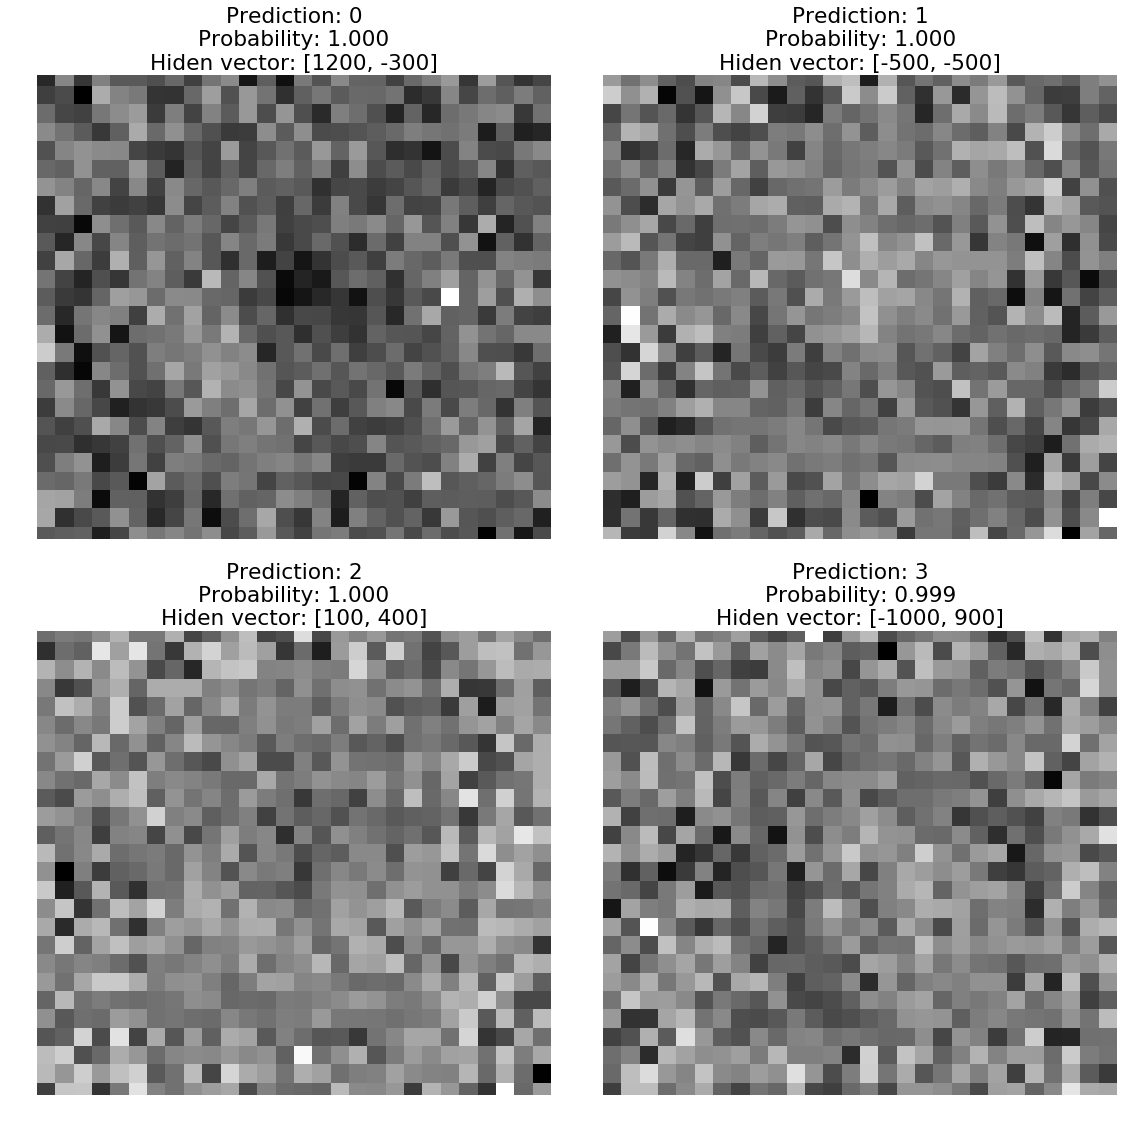

In [ ]:
a0 = [1200, -300]
a1 = [-500, -500]
a2 = [100, 400]
a3 = [-1000, 900]

fig, ax = plt.subplots(2,2, sharex=True, sharey=False, figsize=(16,16))

pity_the_fool(a0, dnn_identity, ax[0, 0])
pity_the_fool(a1, dnn_identity, ax[0, 1])
pity_the_fool(a2, dnn_identity, ax[1, 0])
pity_the_fool(a3, dnn_identity, ax[1, 1])

fig.tight_layout()
fig.savefig('adversarial_examples.png')

The Figures clearly show that I have manged fool the DNN, it is almost liie the DNN had some Mexican peyote or something. The labels are consitent with the regions we took the points from and are classified with a almost 100% probability. There is no way a human eye can tell that those imagines are a 0, a 1, a 2 and a 3, not even to tell there are numbers, is just rubish.

## Light at the end of the tunnel

I have repeated that the main problem is the linear classification boundaries, is there a way we can avoid this? Well, I left a hint out there when I mentioned that the dot product presented is nothing more than a linear Kernel. I will not go into the details of how the [Kernel trick](https://en.wikipedia.org/wiki/Kernel_method) works, but in summary it let us perform dot products in higher dimensional spaces of our features without ever computing the corresponding coordinates in that high-dimensional space, if you never heard about it, it can be a bit of a weird thing. Just to mess more with your cerebro, if for example we were to use the [Gaussian Kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), this is actually equal to performing calculations in an infinite high-dimensional space, yes infinite! [^5]

Then by using these Kernels the model is not restricted to linear classification boundaries. Recall the Multinomial logistic regression example. Below I compare a Support Vector Machine method with a linear Kernel and a Gaussian Kernel.

```python
svm_linear = SVC(kernel='linear', probability=True)
svm_gaussian = SVC(kernel='rbf', probability=True)

```

Both SVM models obtain an accuracy of $\approx 96.6%$.

[^5]: This is because of the Taylor expansion of the exponential function.

In [ ]:
iris_dataset = load_iris()
keep_cols = ['petal length (cm)', 'petal width (cm)']
target_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
iris = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)[keep_cols]
iris['flower'] = iris_dataset.target
iris.flower = iris.flower#.map(target_map)#.astype('category')

In [ ]:
svm_linear = SVC(kernel='linear', probability=True)
svm_linear.fit(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)
svm_linear.score(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)

0.96666666666666667

In [ ]:
svm_gaussian = SVC(kernel='rbf', probability=True)
svm_gaussian.fit(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)
svm_gaussian.score(X=iris.loc[:, iris.columns != 'flower'], y=iris.flower)

0.96666666666666667

In [ ]:
prediction_linear = svm_linear.predict(X=iris.loc[:, iris.columns != 'flower'])
success_linear = prediction_linear == iris['flower']

In [ ]:
prediction_gaussian = svm_gaussian.predict(X=iris.loc[:, iris.columns != 'flower'])
success_gaussian = prediction_gaussian == iris['flower']

In [ ]:
iris['prediction_linear'] = prediction_linear
iris['success_linear'] = success_linear

iris['prediction_gaussian'] = prediction_linear
iris['success_gaussian'] = success_gaussian

iris['prediction_linear'] = iris['prediction_linear'].astype('category')
iris['prediction_gaussian'] = iris['prediction_gaussian'].astype('category')

In [ ]:
def predictions(model):
    predictions = pd.DataFrame(data=np.mgrid[-1:10:100j, -1:5:100j].reshape(2,-1).T,
                             columns=['length', 'width'])
    predictions['prediction'] = model.predict(predictions[['length', 'width']])
    predictions['prediction'] = predictions['prediction'].astype('category')
    predictions['probability'] = np.max(model.predict_proba(predictions[['length', 'width']]), axis=1)
    return predictions

In [ ]:
pred_svm_linear = predictions(svm_linear)
pred_svm_gaussian = predictions(svm_gaussian)

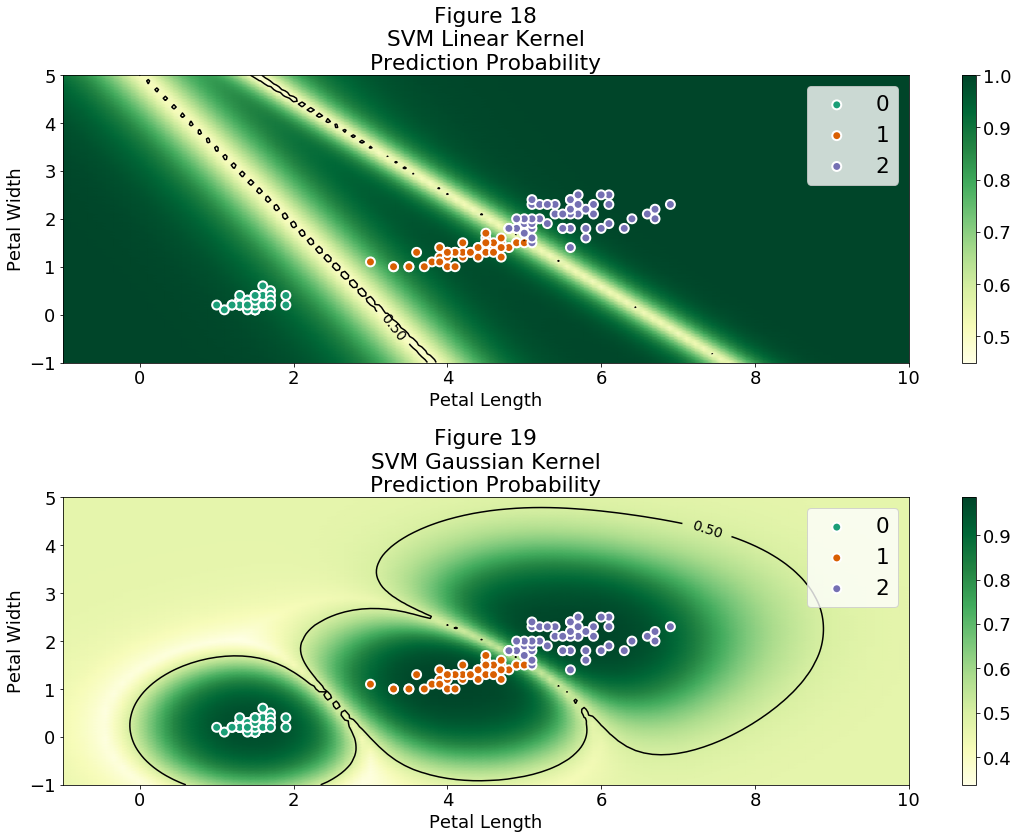

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16,12))

levels = [0.504]
df = pred_svm_linear.pivot(index='width', columns='length', values='probability')
pp = ax[0].pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax[0].contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.colorbar(pp, ax=ax[0])
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)

for label, df in iris.groupby('prediction_linear'):
    df = df.sort_values('success_linear', ascending=False)
    df.plot.scatter('petal length (cm)', 'petal width (cm)', ax=ax[0], label=label,
                    edgecolors='w', linewidths=2, s=80,
                    c=df.prediction_linear.cat.codes.map(lambda x: colormap(x)))
ax[0].set_xlabel('Petal Length')
ax[0].set_ylabel('Petal Width')
ax[0].set_title('Figure 18\nSVM Linear Kernel\nPrediction Probability');

levels = [0.504]
df = pred_svm_gaussian.pivot(index='width', columns='length', values='probability')
pp = ax[1].pcolormesh(df.columns.values, df.index.values, df.values, shading='gouraud', cmap='YlGn')
cs = ax[1].contour(df.columns.values, df.index.values, df.values, 4, colors='k', levels=levels)
plt.colorbar(pp, ax=ax[1])
plt.clabel(cs, levels,
           inline=1,
           fmt='%1.2f',
           fontsize=14)

for label, df in iris.groupby('prediction_gaussian'):
    df = df.sort_values('success_gaussian', ascending=False)
    df.plot.scatter('petal length (cm)', 'petal width (cm)', ax=ax[1], label=label,
                    edgecolors='w', linewidths=2, s=80,
                    c=df.prediction_gaussian.cat.codes.map(lambda x: colormap(x)))
ax[1].set_xlabel('Petal Length')
ax[1].set_ylabel('Petal Width')
ax[1].set_title('Figure 19\nSVM Gaussian Kernel\nPrediction Probability')

fig.tight_layout()
fig.savefig('svm_predictions.png')

Figure 18 shows that the SVM with the linear Kernel also suffers from the issues discussed in this blog post. In general any discriminative model that is trying to model the conditional probability via some transformation of the dot product $\Theta\cdot X$ is doomed to be supceptible to adversarial example attacks. 

Figure 19 is beautiful, shows exactly how getting rid of the linearity ($\Theta\cdot X$) allows for non-linear classification boundaries and hence the regions with high probability do not extend indefinitely. In this case all points with high probability are close the our observations so in principle that should "look" like our observations.

Now, a SVM with a Gaussian Kernel cannot accomplish the extremely complicated tasks that Depp Neural Networks can, but an idea could be to find a way to implement a non-linear Kernel between the last hidden layer and the output layer. This discussion is out of scope but hopefully I will find the time to look into it and write about my findings.

Another solution to the discussed issues lies in a completly different perspective, intead of trying to model the conditional probability, try to model the join probability with generative models, in this way these models should capture the underlaying "context" of our observations and not only what makes them different.  This fundamental difference allows generative algorithms to do things which are impossible for a DNN. Such as producing never seen examples which have a strinking resemblence to original observations, and even more to tune the context of these examples. A super nice [demonstration](https://houxianxu.github.io/assets/project/dfcvae) is the generation of never seen faces where the concept of smiling and sunglasses can be tuned.

Discriminative models in the context of Deep Learning are out of scope but for this blog but a new one is on its way.